<a href="https://colab.research.google.com/github/Michel93DM/Intent_Classification_NLP2023/blob/main/Copy_of_Fine_tuning_CamemBert___intent_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install transformers
! pip install datasets
! pip install pytorch-lightning
! pip install evaluate
! pip install transformers[sentencepiece]
! pip install sentencepiece

import gzip
import shutil
import time

import pandas as pd
import requests
import torch
import torch.nn.functional as F
import torchtext

from pprint import pprint
import functools

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pytorch_lightning as pl

from datasets import load_dataset
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm.notebook import tqdm

import transformers
from transformers import AutoModelForSequenceClassification, CamembertForMaskedLM, AutoTokenizer, AutoConfig, CamembertTokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 30.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 26.5 MB/s eta 0:00:0

### Comprendre CamemBert

In [2]:
camembert = CamembertForMaskedLM.from_pretrained('camembert-base')

camembert = camembert.cuda()

tokenizer = AutoTokenizer.from_pretrained('camembert-base')

KeyboardInterrupt: ignored

In [ ]:
# Visualiser la couches d'embeddings
camembert.roberta.embeddings

In [ ]:
# Visualiser les couches cachées
print(f"Camembert est composé de {len(camembert.roberta.encoder.layer)} couches cachées\n")
print("Voilà une couche cachée :")
camembert.roberta.encoder.layer[0]

#### Exemple avec quelques phrase pour comprendre la procedure

In [ ]:
batch_sentences = [
    "Vous savez où est la <mask> la plus proche?",
    "La Seine est un <mask>.",
    "Je cherche urgemment un endroit où retirer de l'<mask>.",
]

tokenizer = AutoTokenizer.from_pretrained('camembert-base')

tokenizer_output = tokenizer(batch_sentences)

pprint(tokenizer_output, width=150)

In [ ]:
pprint([tokenizer.convert_ids_to_tokens(input_ids) for input_ids in tokenizer_output['input_ids']], width=150)

In [ ]:
tokenizer_output = tokenizer(
    batch_sentences,
    padding="max_length",  # pour le padding
    truncation=True,       # pour ne pas depasser une certaine longueur
    return_tensors="pt"
)
pprint(tokenizer_output, width=150)

### Dataset Loria 

In [3]:
dataset = load_dataset("miam", "loria")
dataset

Generating train split:   0%|          | 0/8465 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/942 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1047 [00:00<?, ? examples/s]

Dataset miam downloaded and prepared to /root/.cache/huggingface/datasets/miam/loria/1.0.0/3cb25c5337f9e60db1dc6d90344763a6ef79d7a4ac3c5f215ce6e8afe99db26c. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 8465
    })
    validation: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 942
    })
    test: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 1047
    })
})

In [4]:
pd_dataset = {split_name: split_data.to_pandas() for split_name, split_data in dataset.items()}
pd_dataset["validation"]

,Speaker,Utterance,Dialogue_Act,Dialogue_ID,File_ID,Label,Idx
0,Samir,Bravo! Vous avez été rapides!,greet,19,Dial_20110530_154627,5,0
1,Samir,Qu'est-ce que je peux faire pour vous?,ask,19,Dial_20110530_154627,1,1
2,Julie,merci,next_step,19,Dial_20110530_154627,17,2
3,Samir,"Eh bien, il va falloir la fabriquer cette mane...",inform,19,Dial_20110530_154627,7,3
4,Samir,"Mais sinon, vous avez encore des questions sur...",ask,19,Dial_20110530_154627,1,4
...,...,...,...,...,...,...,...
937,Julie,Avec plaisir!,yes,1239,Dial_20120104_160514,30,937
938,Sophia,C' est un métier pour lequel il faut être poly...,inform,1239,Dial_20120104_160514,7,938
939,Julie,"Oui, je vois.",ack,1239,Dial_20120104_160514,0,939
940,Sophia,"Je vous laisse les assembler , je les ai posé ...",quit,1239,Dial_20120104_160514,21,940


Le dataset comprend 31 labels.


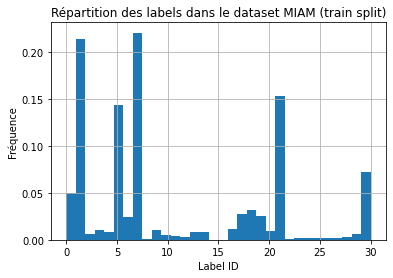

In [5]:
nb_labels = len(pd_dataset["train"]["Label"].unique())
print(f"Le dataset comprend {nb_labels} labels.")

ax = pd_dataset["train"]["Label"].hist(density=True, bins=nb_labels+1)
ax.set_xlabel("Label ID")
ax.set_ylabel("Fréquence")
ax.set_title("Répartition des labels dans le dataset MIAM (train split)")
ax.figure.show()

Ce dataset est donc assez déséquilibré. On peut ensuite s'intéresser à la longueur des chaînes de caractères et vérifier qu'elles sont adaptées à l'utilisation de CamemBERT:

In [ ]:
pd_dataset["train"]["len_utt"] = pd_dataset["train"]["Utterance"].apply(lambda x: len(x))
ax = pd_dataset["train"]["len_utt"].hist(density=True, bins=50)
ax.set_xlabel("Longueur")
ax.set_ylabel("Fréquence")
ax.set_title("Nombre de caractères par phrase")
ax.figure.show()

In [ ]:
def tokenize_batch(samples, tokenizer):
    text = [sample["Utterance"] for sample in samples]
    labels = torch.tensor([sample["Label"] for sample in samples])
    str_labels = [sample["Dialogue_Act"] for sample in samples]
    # The tokenizer handles
    # - Tokenization (amazing right?)
    # - Padding (adding empty tokens so that each example has the same length)
    # - Truncation (cutting samples that are too long)
    # - Special tokens (in CamemBERT, each sentence ends with a special token </s>)
    # - Attention mask (a binary vector which tells the model which tokens to look at. For instance it will not compute anything if the token is a padding token)
    tokens = tokenizer(text, padding="longest", return_tensors="pt")

    return {"input_ids": tokens.input_ids, "attention_mask": tokens.attention_mask, "labels": labels, "str_labels": str_labels, "sentences": text}

Récupérons les trois *splits* du dataset, qui nous seront utiles dans la seconde partie de l'atelier:

In [ ]:
train_dataset, val_dataset, test_dataset = dataset.values()

In [ ]:
val_dataloader = DataLoader(val_dataset, collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer), batch_size=16)
next(iter(val_dataloader))

In [ ]:
sentences = []
labels = []
str_labels = []
all_representations = torch.Tensor()

with torch.no_grad():
    for tokenized_batch in tqdm(val_dataloader):
        model_output = camembert(
            input_ids = tokenized_batch["input_ids"].cuda(),
            attention_mask = tokenized_batch["attention_mask"].cuda(),
            output_hidden_states=True
        )
        batch_representations = average_embeddings(model_output["hidden_states"][-1], tokenized_batch["attention_mask"].cuda())
        sentences.extend(tokenized_batch["sentences"])
        labels.extend(tokenized_batch["labels"])
        str_labels.extend(tokenized_batch["str_labels"])
        all_representations = torch.cat((all_representations, batch_representations), 0)

In [ ]:
num_labels = dataset["train"].features["Label"].num_classes

In [ ]:
num_labels = len(pd.unique(train_dataset["Label"]))

In [ ]:
num_labels

### Start with our Code

In [6]:
def Dataset_representation(example):
    example_validation_U = example['validation']['Utterance']
    example_validation_L = example['validation']['Label']

    df_validation_U = pd.DataFrame (example_validation_U, columns = ['Utterance'])
    df_validation_L = pd.DataFrame (example_validation_L, columns = ['Label'])

    df_validation = pd.merge(df_validation_U, df_validation_L, left_index=True, right_index=True)
    
    example_test_U = example['test']['Utterance']
    example_test_L = example['test']['Label']

    df_test_U = pd.DataFrame (example_test_U, columns = ['Utterance'])
    df_test_L = pd.DataFrame (example_test_L, columns = ['Label'])

    df_test = pd.merge(df_test_U, df_test_L, left_index=True, right_index=True)

    example_train_U = example['train']['Utterance']
    example_train_L = example['train']['Label']
    
    df_train_U = pd.DataFrame (example_train_U, columns = ['Utterance'])
    df_train_L = pd.DataFrame (example_train_L, columns = ['Label'])
    df_train = pd.merge(df_train_U, df_train_L, left_index=True, right_index=True) 
    
    return df_train, df_validation, df_test

In [7]:
df_train, df_valid, df_test = Dataset_representation(dataset)

In [8]:
df_train

,Utterance,Label
0,Alors!,5
1,Il faut que tu trouves l' adresse de l' entrep...,1
2,Où est l'entreprise qu'on cherche ?,6
3,Je ne sais pas... mon oncle a dit que c' était...,7
4,Allez!,21
...,...,...
8460,Bravo! Vous avez été rapides!,5
8461,Qu'est-ce que je peux faire pour vous?,1
8462,Oui c'est ce qu'on me dit assez souvent. Bon i...,17
8463,"d' abord, cherchez la machine qui convient sur...",7


In [9]:
train_texts = df_train['Utterance'].values
train_labels = df_train['Label'].values

valid_texts = df_valid['Utterance'].values
valid_labels = df_valid['Label'].values

test_texts = df_test['Utterance'].values
test_labels = df_test['Label'].values


In [10]:
tokenizer = AutoTokenizer.from_pretrained('camembert-base', num_labels = 31)

train_encodings = tokenizer(list(train_texts), truncation = True, padding = True)
valid_encodings = tokenizer(list(valid_texts), truncation = True, padding = True)
test_encodings = tokenizer(list(test_texts), truncation = True, padding = True)

In [11]:
class MIAMDataset(torch.utils.data.Dataset):
    def __init__ (self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item={key: torch.tensor(val[idx])
             for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)
    
train_dataset = MIAMDataset(train_encodings, train_labels)
valid_dataset = MIAMDataset(valid_encodings, valid_labels)
test_dataset  = MIAMDataset(test_encodings, test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle = True )
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=16, shuffle = False )
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle = False )

In [12]:
from transformers import CamembertModel, CamembertForSequenceClassification
model_Camembert = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels = 31)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_Camembert = model_Camembert.to(device)
model_Camembert.train()

optim = torch.optim.Adam(model_Camembert.parameters(), lr = 5e-5)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight'

In [13]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
recall = evaluate.load("recall")
precision = evaluate.load("precision")
accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy_score = accuracy.compute(predictions=predictions, references=labels)
    f1_micro_score = f1.compute(predictions=predictions, references=labels, average='micro')
    f1_macro_score = f1.compute(predictions=predictions, references=labels, average='macro')
    recall_micro_score = recall.compute(predictions=predictions, references=labels, average='micro')

    return {'Accuracy': accuracy_score,
            'F1_micro': f1_micro_score,
            'F1_macro': f1_macro_score,
            'Recall': recall_micro_score}

In [14]:
from transformers import TrainingArguments, Trainer



In [15]:
training_args = TrainingArguments('test_trainer',
                           evaluation_strategy = 'epoch',
                           num_train_epochs=3, #change to 2 or 3 later
                           logging_dir = './logs',
                           logging_steps = 500,
                           save_strategy="epoch",
                           per_device_train_batch_size = 16,
                           per_device_eval_batch_size = 16,
                           
)

trainer_loria = Trainer(
                           model=model_Camembert,
                           args=training_args,
                           train_dataset=train_dataset,
                           eval_dataset=valid_dataset,
                           optimizers = (optim, None),
                           compute_metrics=compute_metrics,
                           )


trainer_loria.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Micro,F1 Macro,Recall
1,1.463200,0.899679,{'accuracy': 0.7611464968152867},{'f1': 0.7611464968152867},{'f1': 0.19658886678577753},{'recall': 0.7611464968152867}
2,0.796300,0.742712,{'accuracy': 0.8046709129511678},{'f1': 0.8046709129511678},{'f1': 0.2672410508862459},{'recall': 0.8046709129511678}
3,0.640400,0.665519,{'accuracy': 0.8174097664543525},{'f1': 0.8174097664543525},{'f1': 0.27044654339806545},{'recall': 0.8174097664543525}


Trainer is attempting to log a value of "{'accuracy': 0.7611464968152867}" of type <class 'dict'> for key "eval/Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.7611464968152867}" of type <class 'dict'> for key "eval/F1_micro" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.19658886678577753}" of type <class 'dict'> for key "eval/F1_macro" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.7611464968152867}" of type <class 'dict'> for key "eval/Recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8046709129511678}" of type <class '

TrainOutput(global_step=1590, training_loss=0.9456615400014433, metrics={'train_runtime': 475.1305, 'train_samples_per_second': 53.448, 'train_steps_per_second': 3.346, 'total_flos': 1331467564289940.0, 'train_loss': 0.9456615400014433, 'epoch': 3.0})

### Validation Dataset

In [17]:
print(trainer_loria.evaluate())

Trainer is attempting to log a value of "{'accuracy': 0.8174097664543525}" of type <class 'dict'> for key "eval/Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.8174097664543525}" of type <class 'dict'> for key "eval/F1_micro" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.27044654339806545}" of type <class 'dict'> for key "eval/F1_macro" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.8174097664543525}" of type <class 'dict'> for key "eval/Recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.6655194163322449, 'eval_Accuracy': {'accuracy': 0.8174097664543525}, 'eval_F1_micro': {'f1': 0.8174097664543525}, 'eval_F1_macro': {'f1': 0.27044654339806545}, 'eval_Recall': {'recall': 0.8174097664543525}, 'eval_runtime': 4.6978, 'eval_samples_per_second': 200.521, 'eval_steps_per_second': 12.559, 'epoch': 3.0}


In [18]:
predictions = trainer_loria.predict(valid_dataset)
print(predictions.predictions.shape, predictions.label_ids.shape)
preds = np.argmax(predictions.predictions, axis=-1)

(942, 31) (942,)


In [19]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
print(classification_report(preds, valid_labels))

              precision    recall  f1-score   support

           0       0.69      0.61      0.65        59
           1       0.99      0.98      0.98       182
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.95      0.97      0.96       130
           6       0.45      0.65      0.53        20
           7       0.96      0.98      0.97       195
           8       0.00      0.00      0.00         0
           9       0.60      0.16      0.25        19
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       1.00      0.27      0.43        37
          17       0.88    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


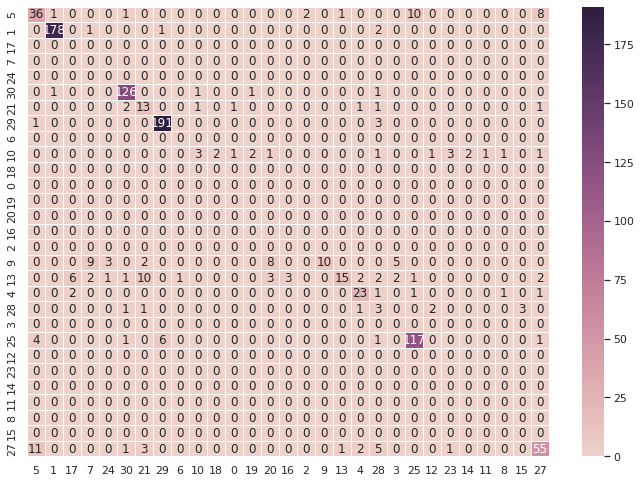

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sn
names = pd.unique(valid_labels)
cm = confusion_matrix(preds, valid_labels)
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(rc={'figure.figsize':(11.7,8.27)})
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap=sn.cubehelix_palette(as_cmap=True), linewidth=0.5, fmt="")
plt.show()

### Test Dataset

In [21]:
predictions_test = trainer_loria.predict(test_dataset)
print(predictions_test.predictions.shape, predictions_test.label_ids.shape)


(1047, 31) (1047,)


In [22]:
preds_test = np.argmax(predictions_test.predictions, axis=-1)

In [23]:
print(classification_report(preds_test, test_labels))

              precision    recall  f1-score   support

           0       0.67      0.56      0.61        54
           1       0.99      0.98      0.99       217
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.95      0.98      0.96       136
           6       0.42      0.76      0.54        17
           7       0.99      0.99      0.99       218
           9       0.82      0.27      0.41        33
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          16       0.83      0.11      0.19        46
          17       0.88      0.41      0.56        54
          18       0.90      0.75      0.82        36
          19       0.31    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


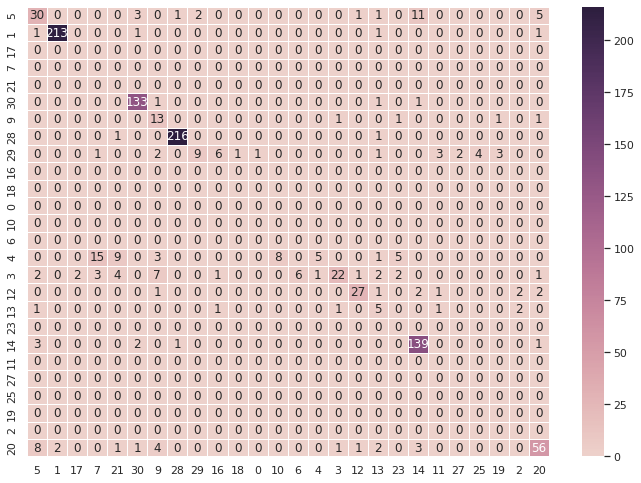

In [24]:
names = pd.unique(test_labels)
cm = confusion_matrix(preds_test, test_labels)
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(rc={'figure.figsize':(11.7,8.27)})
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap=sn.cubehelix_palette(as_cmap=True), linewidth=0.5, fmt="")
plt.show()